# Quickstart

**Acknowledgments:** This notebook adapts the content in [this NCAR tutorial](https://github.com/NCAR/GPU_workshop/blob/workshop/12_CuPyAndLegate/12_CuPyAndLegate.ipynb) to Xarray, and uses it to illustrate `cupy-xarray` and working with cupy arrays and Xarray objects in general.

## Setup

In [1]:
import cupy as cp
import cupy_xarray  # Adds .cupy to Xarray objects
import numpy as np
import xarray as xr

## Creating Arrays

First we create arrays on the CPU and GPU

In [2]:
# NumPy data (host / cpu)
x_cpu = np.linspace(0, 2, 5)
print("On the CPU: ", x_cpu)

# CuPy data
x_gpu = cp.linspace(2, 4, 5)
print("On the GPU: ", x_gpu)

On the CPU:  [0.  0.5 1.  1.5 2. ]
On the GPU:  [2.  2.5 3.  3.5 4. ]


And now wrap those in a Xarray DataArray

In [3]:
da_gpu = xr.DataArray(x_gpu, dims="x")
da_gpu

<xarray.DataArray (x: 5)>
array([2. , 2.5, 3. , 3.5, 4. ])
Dimensions without coordinates: x

That was easy! Xarray seamlessly wraps numpy array-like objects that [support specific protocols](https://docs.xarray.dev/en/stable/internals/duck-arrays-integration.html).

For array-specific functionality Xarray recommends adding new packages that provide ["accessors"](https://docs.xarray.dev/en/stable/internals/extending-xarray.html) on Xarray objects. 

For example, the [pint-xarray](https://pint-xarray.readthedocs.io/en/latest/) package that wraps unit-aware pint arrays and provides a `.pint` for unit-specific functionality.

In this tutorial, we demonstrate `cupy-xarray` which provides a `cupy` accessor that in turn provides access to cupy-specific functionality.

## Checking for cupy arrays

Unfortunately the text representation of CuPy arrays isn't [very informative](https://github.com/cupy/cupy/issues/6926) so it isn't obvious that this DataArray wraps a CuPy array on the GPU.

In [4]:
da_gpu

<xarray.DataArray (x: 5)>
array([2. , 2.5, 3. , 3.5, 4. ])
Dimensions without coordinates: x

Instead we'll use the `is_cupy` property provided by the `cupy` accessor

In [5]:
da_gpu.cupy.is_cupy

True

## Accessing the underlying array

Use the `DataArray.data` property to access the underlying CuPy Array

In [6]:
da_gpu.data

array([2. , 2.5, 3. , 3.5, 4. ])

This means we now have access to CuPy-specific properties

In [7]:
da_gpu.data.device

<CUDA Device 0>

## Moving data between CPU and GPU (or host and device)

Xarray provides [DataArray.as_numpy](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.as_numpy.html#xarray.Dataset.as_numpy) to convert all kinds of arrays to numpy arrays

In [8]:
# Move data to host
da_cpu = da_gpu.as_numpy()
da_cpu

<xarray.DataArray (x: 5)>
array([2. , 2.5, 3. , 3.5, 4. ])
Dimensions without coordinates: x

Let's make sure this isn't a cupy array anymore

In [9]:
da_cpu.cupy.is_cupy

False

To convert a numpy array to a CuPy array (move data to GPU) use `cupy.as_cupy()`

In [10]:
# Move data to GPU
da_cpu.cupy.as_cupy()

<xarray.DataArray (x: 5)>
array([2. , 2.5, 3. , 3.5, 4. ])
Dimensions without coordinates: x

In [11]:
da_cpu.as_cupy().cupy.is_cupy

True

## Most Xarray operations preserve array type


In [12]:
expanded = da_gpu.expand_dims(y=3)
expanded.cupy.is_cupy

True

### Alignment

Alignment is a fundamental Xarray operation. It preserves array types

In [13]:
aligned = xr.align(da_gpu, expanded)
[a.cupy.is_cupy for a in aligned]

[True, True]

### Broadcasting

In [14]:
da_gpu2 = da_gpu.rename({"x": "y"})
broadcasted = xr.broadcast(da_gpu, da_gpu2)
[a.cupy.is_cupy for a in broadcasted]

[True, True]

### Basic Arithmetic

In [15]:
# works on both CPU and GPU
print("is_gpu: ", (da_gpu + 1).cupy.is_cupy)
da_gpu + 1

is_gpu:  True


<xarray.DataArray (x: 5)>
array([3. , 3.5, 4. , 4.5, 5. ])
Dimensions without coordinates: x

### Numpy universal functions

In [16]:
np.min(da_gpu.mean()).cupy.is_cupy

True

We can use `np.round` which dispatches

In [17]:
np.round(da_gpu.mean(), 2).cupy.is_cupy

True

## High-level Xarray functions

### Groupby works

Though this is a slow for loop over groups. We could add an explicit parallel algorithm to [flox](https://github.com/xarray-contrib/flox)

In [18]:
da_gpu.groupby("x").mean(...)

<xarray.DataArray (x: 5)>
array([2. , 2.5, 3. , 3.5, 4. ])
Dimensions without coordinates: x

Since groupby works; groupby_bins and resample *should* also work

### Rolling windows do not work

cupy needs to add support for [sliding_window_view](https://numpy.org/devdocs/reference/generated/numpy.lib.stride_tricks.sliding_window_view.html)

In [19]:
da_gpu.rolling(x=3).mean().cupy.is_cupy

TypeError: no implementation found for 'numpy.lib.stride_tricks.sliding_window_view' on types that implement __array_function__: [<class 'cupy.ndarray'>]

### Weighted operations work

In [20]:
weights = xr.DataArray(cp.asarray([0, 0.5, 1, 0.5, 0]), dims="y")
da_gpu.weighted(weights).sum().cupy.is_cupy

True

## Plotting works

Automatically moves data to the CPU before passing on to matplotlib

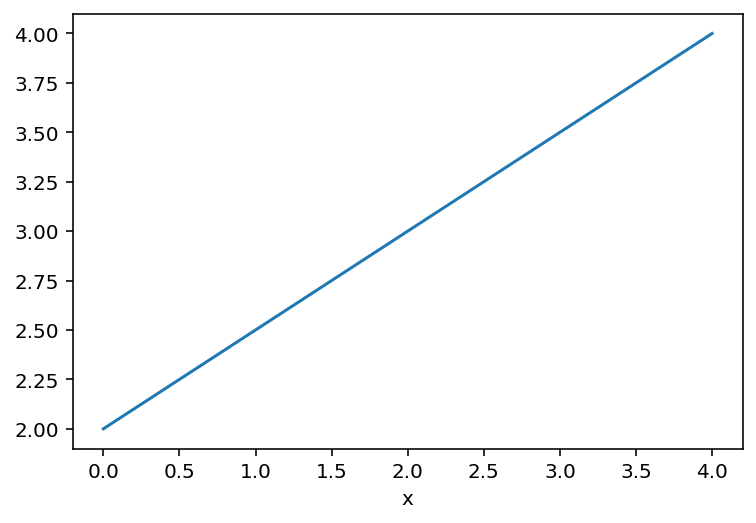

In [21]:
da_gpu.plot()

##  Apply custom kernels with apply_ufunc

(This kernel was copied from [this NCAR tutorial](https://github.com/NCAR/GPU_workshop/blob/workshop/12_CuPyAndLegate/12_CuPyAndLegate.ipynb))

In [22]:
x = cp.arange(6, dtype="f").reshape(2, 3)
y = cp.arange(3, dtype="f")

kernel = cp.ElementwiseKernel(
    "float32 x, float32 y",
    "float32 z",
    """
    if (x - 2 > y) {
      z = x * y;
    } else {
      z = x + y;
    }
    """,
    "my_kernel",
)

kernel(x, y)

array([[ 0.,  2.,  4.],
       [ 0.,  4., 10.]], dtype=float32)

We can apply these and other custom kernels using `xarray.apply_ufunc`

In [23]:
xda = xr.DataArray(x, dims=("a", "b"))
yda = xr.DataArray(y, dims=("b"))
result = xr.apply_ufunc(
    kernel,
    xda,
    yda,
)
print("is_gpu:", result.cupy.is_cupy)
result

is_gpu: True


<xarray.DataArray (a: 2, b: 3)>
array([[ 0.,  2.,  4.],
       [ 0.,  4., 10.]], dtype=float32)
Dimensions without coordinates: a, b